In [152]:
#!/usr/bin/env python3

import sys
import os
import glob
import itertools
import statistics

import pandas as pd
from collections import Counter, defaultdict, OrderedDict
from string import ascii_lowercase

from Bio import AlignIO, SeqIO
from Bio.Alphabet import IUPAC
from Bio.Seq import MutableSeq, translate

from ind import findEnds

In [2]:
def find_dna_subs(read, ref, verbose=False, start_offset=0, end_trail=0):
    """
    @ read, ref: MutableSeq objects
    :return errors - tuple (position, expected triplet, actual triplet, ) / none if broken read
    
    This is intended purely for counting PCR polymerase substitutions.
    The assumption is that the reference includes 0 nt either side of the gene of interest.
    As for HGVS, the starting offset and number of trailing nt are variable
    Letter by letter report mutations in NGS read, all counts 1- based in result (code in 0-count).
    - substitution: 78C = nt 78 in reference is changed to C
    - deletions: 78d6 = 6 nt deleted starting with 78: 1-77, d6, 84-end
    - insertion: 78iATC = after nt 78 inserted seq. ATC
    """

    if read is None:
        if verbose:
            print('no read provided')
        return

#     # find the ends of the read
    ends = findEnds(read, ref, start_offset)

    # scan read & reference letter by letter, counting position in reference
    # reads have been trimmed so that reference starts @ offset=3 by default (0,1,2 is the extra triplet)
    dna_errors = []
    ref_index = ends.get('start') - start_offset
    i = ends.get('start')
    max_i = len(ref) - end_trail
    
    # check for indels
    if str(read).find('-') != -1:
        if verbose:
            print('indel')
        return
    elif str(ref).find('-') != -1:
        if verbose:
            print('indel')
        return
    elif len(ref) != len(read):
        if verbose:
            print('indel')
        return
    else:
        # continue on to scand the read for substitutions
        while i < ends.get('end'):
            if i > max_i:
                break
            # check for differences
            if read[i] == ref[i]:
                ref_index += 1
                i += 1

            else:
                # substitution
                if ref_index > 0:
                    dna_errors += [(str(ref_index + 1), 's', str(read[i]))]
                i += 1
                ref_index += 1


    return tuple(dna_errors)

In [3]:
test_ref = "ATATG"
test_seq = "ATTTG"

d = find_dna_subs(test_seq, test_ref)
print(d)

(('3', 's', 'T'),)


In [4]:
os.chdir("../input_fasta")

The fixed length of sequences means that pre-aligning the sequences is not necessary. I can directly compare each FASTA read with the reference.

In [5]:
# let's analyse to all forward sequences
with open("./TEV_fw.fa", "r") as f:
    ref_seq =  SeqIO.read(f, "fasta", alphabet=IUPAC.ambiguous_dna)

files = glob.glob("/home/mp/InDelScanner/input_fasta/*_fw*")

dna_variant_counts = {}

for f in files:
    # make a dictionary to collect the counts
    fname = f[34:]
    dna_variant_counts[fname] = defaultdict(int)
    
    for var_record in SeqIO.parse(f, "fasta", alphabet=IUPAC.ambiguous_dna):
        dna_d = find_dna_subs(var_record.seq, ref_seq.seq, start_offset = 0, end_trail = 0)
        if dna_d is None:
            print(var_record)
        else:
            dna_variant_counts[fname][len(dna_d)] += 1

In [6]:
max_mutations  = max([max(dna_variant_counts[i].keys()) for i in dna_variant_counts.keys()])

In [7]:
column_order = ['H_fw_1.fa', 'H_fw_3.fa', 'H_fw_5.fa', 
                'H_fw_7.fa', 'H_fw_9.fa', 'H_fw_11.fa', 
                'L_fw_1.fa','L_fw_3.fa', 'L_fw_5.fa', 
                'L_fw_7.fa', 'L_fw_9.fa', 'L_fw_11.fa']

In [8]:
df = OrderedDict()

for fname in column_order:
    df[fname] = [dna_variant_counts[fname][i] for i in range(max_mutations +1)]
    
pd.DataFrame.from_dict(df)

,H_fw_1.fa,H_fw_3.fa,H_fw_5.fa,H_fw_7.fa,H_fw_9.fa,H_fw_11.fa,L_fw_1.fa,L_fw_3.fa,L_fw_5.fa,L_fw_7.fa,L_fw_9.fa,L_fw_11.fa
0,18,0,0,0,0,0,41,17,10,0,0,2
1,23,4,0,0,1,0,36,25,13,0,0,1
2,24,9,0,0,3,0,7,20,16,1,0,0
3,13,20,4,2,2,0,4,14,19,3,8,4
4,3,23,3,0,3,0,1,10,10,16,23,6
5,5,15,11,7,4,2,0,0,14,27,19,9
6,2,8,10,8,12,3,1,1,5,15,13,25
7,0,7,13,11,12,7,0,1,1,16,12,14
8,0,2,17,16,13,10,0,1,1,10,4,9
9,0,3,12,17,10,14,0,0,0,5,5,13


In [9]:
# now let's analyse to all second half sequences
with open("./TEV_rv.fa", "r") as f:
    wt_end =  SeqIO.read(f, "fasta", alphabet=IUPAC.ambiguous_dna)

dna_variant_counts = {}

files = glob.glob("/home/mp/InDelScanner/input_fasta/*_rv*")

for f in files:
    # make a dictionary to collect the counts
    fname = f[34:]
    dna_variant_counts[fname] = defaultdict(int)
    
    for var_record in SeqIO.parse(f, "fasta", alphabet=IUPAC.ambiguous_dna):
        dna_d = find_dna_subs(var_record.seq, wt_end.seq, start_offset = 0, end_trail = 0)
        if dna_d is None:
            print(var.record)
        else:
            dna_variant_counts[fname][len(dna_d)] += 1

observed_counts = [list(dna_variant_counts[i].keys()) for i in dna_variant_counts.keys()]
max_mutations = max(list(itertools.chain.from_iterable(observed_counts))) #  this tolerates an empty input file

In [10]:
dna_variant_counts.keys()

dict_keys(['H_rv_1.fa', 'H_rv_11.fa', 'H_rv_3.fa', 'H_rv_5.fa', 'H_rv_7.fa', 'H_rv_9.fa', 'L_rv_1.fa', 'L_rv_11.fa', 'L_rv_3.fa', 'L_rv_5.fa', 'L_rv_7.fa', 'L_rv_9.fa', 'TEV_rv.fa'])

In [11]:
column_order = ['H_rv_1.fa', 'H_rv_3.fa','H_rv_5.fa',
                'H_rv_7.fa', 'H_rv_9.fa','H_rv_11.fa',
                'L_rv_1.fa', 'L_rv_3.fa', 'L_rv_5.fa',
                'L_rv_7.fa', 'L_rv_9.fa', 'L_rv_11.fa']

In [12]:
df = OrderedDict()

for fname in column_order:
    df[fname] = [dna_variant_counts[fname][i] for i in range(max_mutations +1)]
    
pd.DataFrame.from_dict(df)

,H_rv_1.fa,H_rv_3.fa,H_rv_5.fa,H_rv_7.fa,H_rv_9.fa,H_rv_11.fa,L_rv_1.fa,L_rv_3.fa,L_rv_5.fa,L_rv_7.fa,L_rv_9.fa,L_rv_11.fa
0,14,0,0,0,0,0,48,13,11,0,0,0
1,25,4,0,0,0,0,47,28,17,1,0,0
2,27,4,0,0,0,0,8,21,26,1,0,0
3,11,7,0,0,0,0,7,15,17,5,1,0
4,8,12,2,0,3,0,0,12,14,9,1,0
5,7,18,2,0,1,0,1,4,4,19,1,1
6,0,12,6,0,2,3,0,0,5,27,2,0
7,0,13,9,0,5,2,0,0,1,17,11,11
8,0,11,15,0,5,8,0,0,0,9,16,24
9,0,8,20,0,8,5,0,0,0,6,13,23


## Boxplots: number of nucleotide changes per variant

In [89]:
def count_nt_subs_disaggregated(ref_file, files_to_analyse, dna_variant_counts):
    
    for f in files_to_analyse:
        # make a dictionary to collect the counts
        fname = f[34:]
        dna_variant_counts[fname] = []

        for var_record in SeqIO.parse(f, "fasta", alphabet=IUPAC.ambiguous_dna):
            dna_d = find_dna_subs(var_record.seq, ref_file.seq, start_offset = 0, end_trail = 0)
            if dna_d is None:
                print(var.record)
            else:
                # filter out the indels
                # get the tuple[1] positions which should all be 's' for substitutions
                s = 0
                for p in dna_d:
                    if p[1] == 's':
                        s += 1
                    else:
                        print(dna_d)
                        break

                dna_variant_counts[fname].append(s)
                
    return dna_variant_counts

In [92]:
dna_variant_counts = {}

with open("./TEV_rv.fa", "r") as f:
    wt_end =  SeqIO.read(f, "fasta", alphabet=IUPAC.ambiguous_dna)

files = glob.glob("/home/mp/InDelScanner/input_fasta/*_rv*")

dna_variant_counts = count_nt_subs_disaggregated(wt_end, files, dna_variant_counts)

# now add the forward files

with open("./TEV_fw.fa", "r") as f:
    wt_fw =  SeqIO.read(f, "fasta", alphabet=IUPAC.ambiguous_dna)

files = glob.glob("/home/mp/InDelScanner/input_fasta/*_fw*")

dna_variant_counts = count_nt_subs_disaggregated(wt_fw, files, dna_variant_counts)

In [136]:
# set the desired order for boxplots
label_order = ['1_fw', '1_rv', '3_fw', '3_rv', '5_fw', '5_rv', '7_fw', '7_rv', '9_fw', '9_rv', '11_fw', '11_rv']

file_order_high = ['H_fw_1.fa', 'H_rv_1.fa',
                   'H_fw_3.fa', 'H_rv_3.fa',
                   'H_fw_5.fa', 'H_rv_5.fa', 
                   'H_fw_7.fa', 'H_rv_7.fa', 
                   'H_fw_9.fa', 'H_rv_9.fa',
                   'H_fw_11.fa', 'H_rv_11.fa']

file_order_low = ['L_fw_1.fa', 'L_rv_1.fa',  
                  'L_fw_3.fa', 'L_rv_3.fa', 
                  'L_fw_5.fa', 'L_rv_5.fa', 
                  'L_fw_7.fa', 'L_rv_7.fa', 
                  'L_fw_9.fa', 'L_rv_9.fa',
                  'L_fw_11.fa', 'L_rv_11.fa']             

In [121]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [106]:
positions = [1, 2, 
             4, 5,
             7, 8,
             10, 11, 
             13, 14, 
             16, 17]

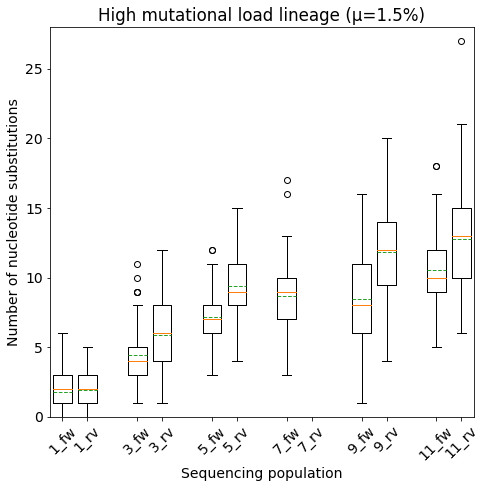

In [137]:
plt.rcParams["figure.figsize"] = [7,7]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()

ax.boxplot([dna_variant_counts[k] for k in file_order_high], positions = positions, widths = 0.75,
          showmeans=True, meanline=True)
ax.set_xticklabels(label_order)
ax.set_ylim([0, 28])

ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('Sequencing population')
ax.set_ylabel('Number of nucleotide substitutions')
ax.set_title('High mutational load lineage (μ=1.5%)')

plt.show()

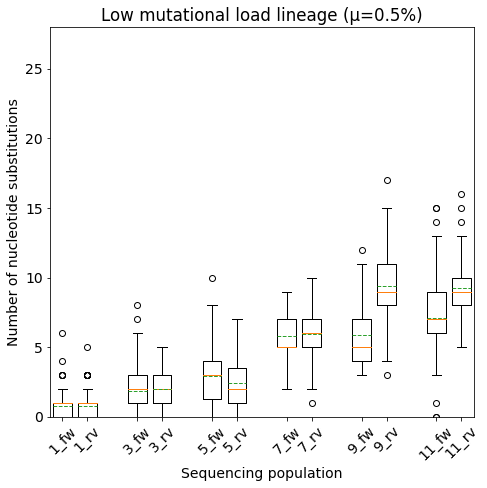

In [126]:
plt.rcParams["figure.figsize"] = [7,7]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()

ax.boxplot([dna_variant_counts[k] for k in file_order_low], positions = positions, widths = 0.75,
          showmeans=True, meanline=True)
ax.set_xticklabels(label_order)
ax.set_ylim([0, 28])

ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('Sequencing population')
ax.set_ylabel('Number of nucleotide substitutions')
ax.set_title('Low mutational load lineage (μ=0.5%)')

plt.show()

# add both distributions together: model each sequence A added to each sequence B

In [132]:
dna_variant_counts.keys()

dict_keys(['H_rv_1.fa', 'H_rv_11.fa', 'H_rv_3.fa', 'H_rv_5.fa', 'H_rv_7.fa', 'H_rv_9.fa', 'L_rv_1.fa', 'L_rv_11.fa', 'L_rv_3.fa', 'L_rv_5.fa', 'L_rv_7.fa', 'L_rv_9.fa', 'TEV_rv.fa', 'H_fw_1.fa', 'H_fw_11.fa', 'H_fw_3.fa', 'H_fw_5.fa', 'H_fw_7.fa', 'H_fw_9.fa', 'L_fw_1.fa', 'L_fw_11.fa', 'L_fw_3.fa', 'L_fw_5.fa', 'L_fw_7.fa', 'L_fw_9.fa', 'TEV_fw.fa'])

In [133]:
file_order_high

['H_fw_1.fa',
 'H_rv_1.fa',
 'H_fw_3.fa',
 'H_rv_3.fa',
 'H_fw_5.fa',
 'H_rv_5.fa',
 'H_fw_7.fa',
 'H_rv_7.fa',
 'H_fw_9.fa',
 'H_rv_9.fa',
 'H_rv_11.fa',
 'H_fw_11.fa']

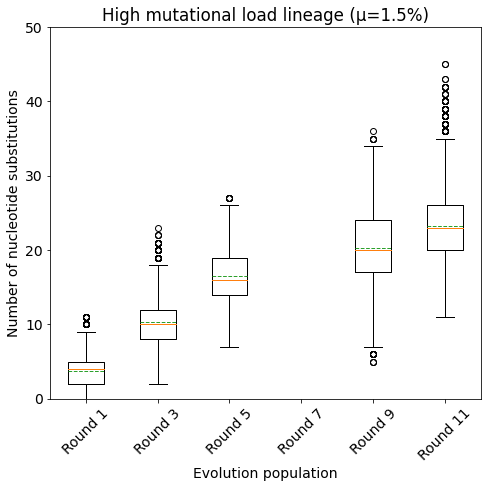

In [154]:
round_order = ['Round 1', 'Round 3', 'Round 5', 'Round 7', 'Round 9', 'Round 11']

full_length_dna = {k : [] for k in label_order}

# let's start with high
f_order = file_order_high
# I can use the fact that the files are ordered in pairs for the boxplots
for i in range(len(label_order)):
    round_name = round_order[i]
    fw_name = f_order[2*i]
    rv_name = f_order[2*i+1]
    for variant_fw in dna_variant_counts[fw_name]:
        for variant_rv in dna_variant_counts[rv_name]:
            full_length_dna[round_name].append(variant_fw + variant_rv)
            
plt.rcParams["figure.figsize"] = [7,7]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()

ax.boxplot(full_length_dna.values(), showmeans=True, meanline=True)
ax.set_xticklabels(round_order)
ax.set_ylim([0, 50])

ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('Evolution population')
ax.set_ylabel('Number of nucleotide substitutions')
ax.set_title('High mutational load lineage (μ=1.5%)')

plt.show()

In [157]:
for k, v in full_length_dna.items():
    try:
        m = statistics.median(v)
    except :
        continue
    print(k, "Median nt changes:", m)

Round 1 Median nt changes: 4.0
Round 3 Median nt changes: 10
Round 5 Median nt changes: 16.0
Round 9 Median nt changes: 20.0
Round 11 Median nt changes: 23.0


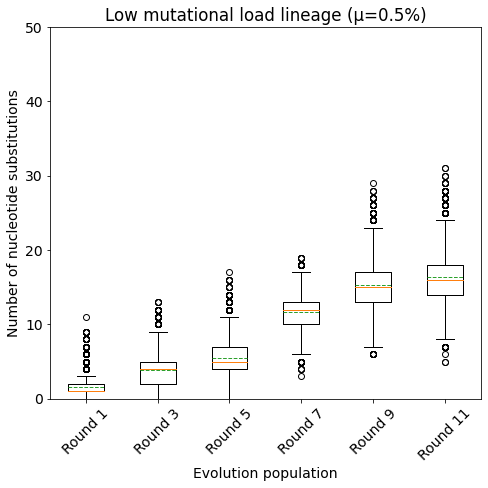

In [150]:
round_order = ['Round 1', 'Round 3', 'Round 5', 'Round 7', 'Round 9', 'Round 11']

full_length_dna = {k : [] for k in label_order}

# let's start with high
f_order = file_order_low
# I can use the fact that the files are ordered in pairs for the boxplots
for i in range(len(label_order)):
    round_name = round_order[i]
    fw_name = f_order[2*i]
    rv_name = f_order[2*i+1]
    for variant_fw in dna_variant_counts[fw_name]:
        for variant_rv in dna_variant_counts[rv_name]:
            full_length_dna[round_name].append(variant_fw + variant_rv)
            
plt.rcParams["figure.figsize"] = [7,7]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()

ax.boxplot(full_length_dna.values(), showmeans=True, meanline=True)
ax.set_xticklabels(round_order)
ax.set_ylim([0, 50])

ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('Evolution population')
ax.set_ylabel('Number of nucleotide substitutions')
ax.set_title('Low mutational load lineage (μ=0.5%)')

plt.show()

In [153]:
for k, v in full_length_dna.items():
    print(k, "Median nt changes:", statistics.median(v))

Round 1 Median nt changes: 1.0
Round 3 Median nt changes: 4
Round 5 Median nt changes: 5.0
Round 7 Median nt changes: 12
Round 9 Median nt changes: 15.0
Round 11 Median nt changes: 16.0


### Protein sequence variation

-	Forward files contain AA 2-121
-	Reverse files contain AA 122-236, also in forward read orientation; thus naming the files as reverse is misleading.


In [14]:
def find_protein_diff(read, ref, verbose=False, start_offset=3, end_trail=3):

    # quality control
    if read is None:
        return None, None
    ends = findEnds(read, ref, start_offset)
#     if not endMatch(read, ref, ends):
#         return None, None

    newread = read
    newref = ref

    # scan reference triplet by triplet
    # move letters when encountering an indel
    prot_errors = []
    prot_short = []

    i = ends.get('aligned')
    ref_index = int((ends.get('aligned') - start_offset)/3) + 1  # reference amino acid index
    max_i = len(ref) - end_trail

    while i <= ends.get('end'):
        if i > max_i:
            break

        if newread is None:
            break
        ref_codon = newref[i:i+3]
        read_codon = newread[i:i+3]

        if '-' in read_codon:  # found a deletion
            # Check if this is the last acid, and it's incomplete, ignore it.
            if re.search('[ATGC]', str(newread[i + 3:])) is None:
                break

            if '-' in ref_codon:  # something very broken
                prot_errors.append((ref_index, 'f'))
                prot_short.append('f')
                break
            elif read_codon == '---':  # single codon deletion
                if ref_index > 0:
                    prot_errors += [(ref_index, 'd')]
                    prot_short.append(str(ref_index) + 'Δ')
                i += 3
                ref_index += 1

            else:  # check it's not a frame shift
                l = indel_len(newread, i)
                if l % 3 != 0:
                    prot_errors.append((ref_index, 'f'))
                    prot_short.append('f')
                    break
                # realign gap and repeat loop at same position to compare the codons
                gap = findGap(newread[i - 1:])
                gap = (gap[0] + i - 1, gap[1] + i - 1)
                newread = gapAlign(newread, gap, start_offset)
                continue

        elif '-' in ref_codon:  # found an insertion
            l = indel_len(newref, i)
            if l % 3 != 0:
                prot_errors.append((ref_index, 'f'))
                prot_short.append('f')
                break
            gap = findGap(newref[i-1:])
            if gap[0] == 1:  # insertion after codon
                insertion = newread[gap[0] + i - 1:gap[1] + i - 1]
                if '-' in insertion:
                    prot_errors.append((ref_index, 'f'))
                    prot_short.append('f')
                    break
                if ref_index > 0:
                    prot_errors.append((ref_index - 1, 'i', str(translate(insertion)))) # position before + insertion
                    stop, inslist = format_insertion(ref_index - 1, insertion)
                    prot_short += inslist
                    if stop:
                        break
                i += l
                ref_index += 1
            else:  # realign gap and repeat loop at same position to compare the codons
                gap = (gap[0] + i - 1, gap[1] + i - 1)
                newref = gapAlign(newref, gap, start_offset)
                continue

        elif translate(read_codon) != translate(ref_codon):  # must be a substitution
            if ref_index > 0:
                prot_errors.append((ref_index, 's', str(translate(read_codon))))
                prot_short.append(str(translate(ref_codon) + str(ref_index) + str(translate(read_codon))))
            if str(translate(read_codon)) == '*':
                break
            i += 3
            ref_index += 1

        else:
            i += 3
            ref_index += 1

    if verbose:
        print(prot_errors)

    if prot_short == []:
        short = 'wt'
    else:
        short = '/'.join(prot_short)

    return tuple(prot_errors), short


In [15]:
# test protein_diff function for numbering

test_ref =  "AAGAGCTTGTTTAAGGGGCCGCGTGATTACAACCCGATATCGAGCACCATTTGTCATTTGACGAATGAATCTGATGGGCACACAACATCGTTGTATGGTATTGGATTTGGTCCCTTCATCATTACAAACAAGCACTTGTTTAGAAGAAATAATGGAACACTGTTGGTCCAATCACTACATGGTGTATTCAAGGTCAAGAACACCACGACTTTGCAACAACACCTCATTGATGGGAGGGACATGATAATTATTCGCATGCCTAAGGATTTCCCACCATTTCCTCAAAAGCTGAAATTTAGAGAGCCACAAAGGGAAGAGCGCATATGTCTTGTGACAACCAACTTCCAAACTAAGAGCATG"
test_read = "AAGAGCTTGTTTAAGGGGCCGCGTGATTACAACCCGATATCGAGCACCATTTGTCATTTGACGAATGAATCTGATGGGCACACAACATCGCTGTATGGTATTGGATTTGGTCCCTTCGTCATTACAAACAAGCACTTGTTTAGAAGAAATAATGGAACACTGTTGGTCCAATCACTACATGGTGTATTCAAGGTCAAGAACACCACGACTTTGCAACAACACCTCATTGATGGGAGGGACATGATAATTATTCGCATGCCTAAGGATTTCCCACCATTTCCTCAAAAGCTGACATTTAGAGAGCCACAAAGGGAAGAGCGCCTATGTCTTGTGACAACCAACTTCCAAACTAAGAGCAGG"

print(find_dna_subs(test_read, test_ref))
find_protein_diff(test_read, test_ref, start_offset = -3, end_trail = 0)

# since first AA should be position 2, use start_offset -3
# I need to disable end matching from the find_protein_diff function

(('91', 's', 'C'), ('118', 's', 'G'), ('293', 's', 'C'), ('322', 's', 'C'), ('359', 's', 'G'))


(((41, 's', 'V'), (99, 's', 'T'), (109, 's', 'L'), (121, 's', 'R')),
 'I41V/K99T/I109L/M121R')

In [16]:
# now let's analyse all first half sequences
with open("./TEV_fw.fa", "r") as f:
    ref_seq =  SeqIO.read(f, "fasta", alphabet=IUPAC.ambiguous_dna)

variant_counts = {}

files = glob.glob("/home/mp/InDelScanner/input_fasta/*_fw*")

for f in files:
    # make a dictionary to collect the counts
    fname = f[34:]
    variant_counts[fname] = defaultdict(int)
    
    for var_record in SeqIO.parse(f, "fasta", alphabet=IUPAC.ambiguous_dna):
        dna_d = find_dna_subs(var_record.seq, ref_seq.seq, start_offset = 0, end_trail = 0)
        if dna_d is None:
            print(var.record)
        else:
            protein_d, prot_short = find_protein_diff(var_record.seq, ref_seq.seq, start_offset = -3, end_trail = 0)
            variant_counts[fname][len(protein_d)] += 1

In [17]:
observed_counts = [list(variant_counts[i].keys()) for i in variant_counts.keys()]
max_mutations = max(list(itertools.chain.from_iterable(observed_counts))) #  this tolerates an empty input file
max_mutations

12

In [18]:
column_order = ['H_fw_1.fa', 'H_fw_3.fa', 'H_fw_5.fa', 
                'H_fw_7.fa', 'H_fw_9.fa', 'H_fw_11.fa', 
                'L_fw_1.fa','L_fw_3.fa', 'L_fw_5.fa', 
                'L_fw_7.fa', 'L_fw_9.fa', 'L_fw_11.fa']

In [19]:
df = OrderedDict()

for fname in column_order:
    df[fname] = [variant_counts[fname][i] for i in range(max_mutations +1)]
    
pd.DataFrame.from_dict(df)

,H_fw_1.fa,H_fw_3.fa,H_fw_5.fa,H_fw_7.fa,H_fw_9.fa,H_fw_11.fa,L_fw_1.fa,L_fw_3.fa,L_fw_5.fa,L_fw_7.fa,L_fw_9.fa,L_fw_11.fa
0,25,4,0,0,0,0,53,25,15,0,0,2
1,30,21,4,2,2,0,28,28,22,1,0,2
2,23,23,10,1,5,2,5,21,18,3,2,4
3,6,18,16,7,12,11,4,11,24,20,22,13
4,2,11,16,31,20,13,0,2,8,31,28,17
5,2,8,14,20,20,26,0,1,0,22,23,22
6,0,5,10,13,15,17,0,1,3,14,11,19
7,0,2,4,8,10,8,0,0,0,0,7,9
8,0,1,3,4,3,13,0,0,0,2,1,4
9,0,0,0,4,3,3,0,0,0,0,0,2


### And repeat the process for the second half of protein sequences

In [21]:
# now let's analyse all first half sequences
with open("./TEV_rv.fa", "r") as f:
    ref_seq =  SeqIO.read(f, "fasta", alphabet=IUPAC.ambiguous_dna)

variant_counts = {}

files = glob.glob("/home/mp/InDelScanner/input_fasta/*_rv*")

for f in files:
    # make a dictionary to collect the counts
    fname = f[34:]
    variant_counts[fname] = defaultdict(int)
    
    for var_record in SeqIO.parse(f, "fasta", alphabet=IUPAC.ambiguous_dna):
        dna_d = find_dna_subs(var_record.seq, ref_seq.seq, start_offset = 0, end_trail = 0)
        if dna_d is None:
            print(var.record)
        else:
            protein_d, prot_short = find_protein_diff(var_record.seq, ref_seq.seq, start_offset = -3, end_trail = 0)
            variant_counts[fname][len(protein_d)] += 1

In [22]:
observed_counts = [list(variant_counts[i].keys()) for i in variant_counts.keys()]
max_mutations = max(list(itertools.chain.from_iterable(observed_counts))) #  this tolerates an empty input file
max_mutations

11

In [23]:
column_order = ['H_rv_1.fa', 'H_rv_3.fa','H_rv_5.fa',
                'H_rv_7.fa', 'H_rv_9.fa','H_rv_11.fa',
                'L_rv_1.fa', 'L_rv_3.fa', 'L_rv_5.fa',
                'L_rv_7.fa', 'L_rv_9.fa', 'L_rv_11.fa']

In [42]:
# make aggregate dict for easy variant counts presentation & mutation rate calculation
dct = OrderedDict()

for fname in column_order:
    dct[fname] = [variant_counts[fname][i] for i in range(max_mutations +1)]
    
df = pd.DataFrame.from_dict(dct)
df

,H_rv_1.fa,H_rv_3.fa,H_rv_5.fa,H_rv_7.fa,H_rv_9.fa,H_rv_11.fa,L_rv_1.fa,L_rv_3.fa,L_rv_5.fa,L_rv_7.fa,L_rv_9.fa,L_rv_11.fa
0,22,0,0,0,0,0,62,23,18,1,0,0
1,24,15,0,0,2,1,37,35,28,9,0,0
2,28,11,4,0,7,2,10,20,22,9,2,2
3,11,27,15,0,8,9,1,11,20,23,3,1
4,6,21,31,0,21,19,1,3,4,26,16,18
5,1,6,18,0,16,19,0,1,3,15,20,26
6,0,7,13,0,12,17,0,0,0,9,19,28
7,0,5,7,0,21,15,0,0,0,3,16,2
8,0,2,6,0,3,5,0,0,0,0,1,3
9,0,1,0,0,5,4,0,0,0,0,6,3


In [26]:
print(ref_seq)

ID: wtTEV/1-348
Name: wtTEV/1-348
Description: wtTEV/1-348
Number of features: 0
Seq('TCTAGCATGGTGTCAGACACTAGTTGCACATTCCCTTCATCTGATGGCATATTC...TAA', IUPACAmbiguousDNA())


## Expand the boxplots for counting mutations to consider sy

In [75]:
# start looking at the type of protein change: synonimous, non-synonimous, stop
with open("./TEV_fw.fa", "r") as f:
    ref_seq =  SeqIO.read(f, "fasta", alphabet=IUPAC.ambiguous_dna)

variant_counts = {}

files = glob.glob("/home/mp/InDelScanner/input_fasta/*_fw*")

for f in files:
    # make a dictionary to collect the counts
    fname = f[34:]
    variant_counts[fname] = defaultdict(int)
    
    for var_record in SeqIO.parse(f, "fasta", alphabet=IUPAC.ambiguous_dna):
        dna_d = find_dna_subs(var_record.seq, ref_seq.seq, start_offset = 0, end_trail = 0)
        if dna_d is None:
            print(var.record)
        else:
            protein_d, prot_short = find_protein_diff(var_record.seq, ref_seq.seq, start_offset = -3, end_trail = 0)


((41, 's', 'V'), (99, 's', 'T'), (109, 's', 'L'))
((75, 's', 'Y'),)
()
((52, 's', 'I'),)
((11, 's', '*'),)
((74, 's', 'H'),)
((27, 's', 'V'), (45, 's', 'M'), (96, 's', '*'))
((16, 's', 'X'), (73, 's', 'R'), (100, 's', 'L'), (106, 's', 'K'), (110, 's', 'S'))
((82, 's', 'L'),)
((114, 's', 'X'),)
()
((24, 's', 'K'), (67, 's', 'E'), (112, 's', 'L'))
()
((100, 's', 'S'),)
()
((37, 's', 'L'), (112, 's', 'E'))
()
((15, 's', 'T'),)
((8, 's', 'L'), (33, 's', 'F'))
((5, 's', 'S'), (11, 's', 'N'))
()
((119, 's', 'X'),)
((67, 's', 'E'), (101, 's', 'G'))
()
((99, 's', 'I'),)
((3, 's', 'C'), (9, 's', 'C'), (16, 's', 'G'), (56, 's', '*'))
()
()
((10, 's', 'E'), (19, 's', '*'))
((55, 's', 'M'),)
((12, 's', 'D'), (72, 's', 'F'))
()
((36, 's', '*'),)
((113, 's', 'A'), (115, 's', 'S'), (121, 's', 'V'))
((45, 's', 'R'), (52, 's', 'S'))
((52, 's', 'I'),)
((32, 's', 'M'), (36, 's', 'V'), (67, 's', 'T'), (110, 's', 'S'))
((37, 's', 'X'), (75, 's', 'Q'))
((4, 's', 'M'), (60, 's', 'I'))
((16, 's', 'R'), (114, 

In [52]:
df['number_mutations'] = df.index

In [73]:
split_df = np.repeat(df['number_mutations'], df['H_rv_9.fa'])

split_df.describe()

count    95.000000
mean      5.178947
std       1.923975
min       1.000000
25%       4.000000
50%       5.000000
75%       7.000000
max       9.000000
Name: number_mutations, dtype: float64

In [59]:
(np.repeat(df['number_mutations'], df['H_rv_1.fa']).mean())

1.5434782608695652

In [60]:
split_df = np.repeat(df['number_mutations'], df['H_rv_1.fa'])

In [63]:
split_df

0    0
0    0
0    0
0    0
0    0
    ..
4    4
4    4
4    4
4    4
5    5
Name: number_mutations, Length: 92, dtype: int64

In [47]:
df.index

RangeIndex(start=0, stop=12, step=1)

In [40]:
df

A         B         C         D
lvl0 lvl1                                        
0    0    -1.401788  0.750093  0.563291 -1.303090
     1    -0.533822 -0.151212  0.933950 -0.036001
     2     0.776942  0.370077  1.370787 -1.176403
     3    -1.160446 -0.025839  0.659636  0.358644
1    0    -0.097905  0.732938  1.298178  0.051173
...             ...       ...       ...       ...
998  3     1.146289  0.693908  1.048187  1.011353
999  0    -0.343728  0.360537 -0.462031 -0.251723
     1    -0.757108  0.740133  0.361275  0.319980
     2    -0.772395  0.465534 -1.129330 -3.332853
     3     1.530605  1.510919  2.148042  0.819181

[4000 rows x 4 columns]